In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
import os
import reducing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
# Loading in all data to pd dataframes
property2016 = pd.read_csv("./Zillow-Data/properties_2016.csv",low_memory = False)
property2017 = pd.read_csv("./Zillow-Data/properties_2017.csv",low_memory = False)
train2016 = pd.read_csv("./Zillow-Data/train_2016_v2.csv")
train2017 = pd.read_csv("./Zillow-Data/train_2017.csv")

# """
# reducing the size of the data stored with some brilliant code from:
# originally by Kirgsn on kaggle: https://www.kaggle.com/code/wkirgsn/fail-safe-parallel-memory-reduction/comments
# which was refined by Etienne Tremblay: https://www.kaggle.com/code/etremblay/fail-safe-parallel-memory-reduction/notebook
# 
# As this code doesn't directly apply to the semester project and is just an ease of life item for cleaning up and making 
# the raw dataframes smaller and easier to manage I felt it was fine to include, however just note that this project would 
# function identically if this code was removed.
# """
# property2016 = reducing.Reducer().reduce(property2016_raw)
# property2017 = reducing.Reducer().reduce(property2017_raw)
# train2016 = reducing.Reducer().reduce(train2016_raw)
# train2017 = reducing.Reducer().reduce(train2017_raw)

There look to be a lot of null values so This will look into which columns have the most

In [ ]:
"""
Code for displaying the number of missing values taken from 
https://github.com/ojasphansekar/Zillow-Home-Value-Prediction/blob/master/Project.ipynb

Again, this code doesn't directly apply to the semester project of creating a machine learning model 
and is just an ease of life item for visualizing the number of Null values in each column I felt it was fine to include, 
however just note that this project would function identically if this code was removed.
"""
missing_df = property2017.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

### Original testing code to make sure the model works

"""
If a column has more than 50% of the values missing it gets removed from the utilized columns
"""
NULL_CUTOFF_VALUE = 0.5
missing_df['missing_pct'] = missing_df['missing_count'] / property2017.shape[0]
good_features = missing_df[missing_df['missing_pct'] < NULL_CUTOFF_VALUE]

if 'parcelid' not in good_features['column_name'].values:
    good_features = pd.concat([good_features, pd.DataFrame([['parcelid', 0, 0]],columns=['column_name', 'missing_count', 'missing_pct'])],ignore_index=True)

property2017_subset = property2017[good_features['column_name']]

train_df = pd.merge(train2017, property2017_subset, on='parcelid', how='left')


train_df['propertyzoningdesc'], zoning_labels = pd.factorize(train_df['propertyzoningdesc'])

train_df['propertycountylandusecode'], land_use_labels = pd.factorize(train_df['propertycountylandusecode'])


In [ ]:
# def prepare_data(train_data, property_data, missing_data, null_cutoff=0.5):
# 
#     missing_data['missing_pct'] = missing_data['missing_count'] / property_data.shape[0]
#     good_features = missing_data[missing_data['missing_pct'] < null_cutoff]
# 
#     if 'parcelid' not in good_features['column_name'].values:
#         good_features = pd.concat([good_features, pd.DataFrame([['parcelid', 0, 0]],
#                                                                columns=['column_name', 'missing_count',
#                                                                         'missing_pct'])], ignore_index=True)
# 
#     property_data_subset = property_data[good_features['column_name']]
# 
#     columns_to_drop = ['propertyzoningdesc', 'propertycountylandusecode']
#     for column in columns_to_drop:
#         property_data_subset = property_data_subset.drop(column, errors='ignore')
#         train_data = train_data.drop(column, errors='ignore')
# 
#     result_df = pd.merge(train_data, property_data_subset, on='parcelid', how='left')
# 
#     return result_df
# 
# missing_data2016 = property2016.isnull().sum().reset_index().rename(
#     columns={'index': 'column_name', 0: 'missing_count'})
# missing_data2017 = property2017.isnull().sum().reset_index().rename(
#     columns={'index': 'column_name', 0: 'missing_count'})
# 
# # Use your 'prepare_data' function
# train2016 = prepare_data(train2016, property2016, missing_data2016)
# train2017 = prepare_data(train2017, property2017, missing_data2017)

# Combine into one giant df
# train_df = pd.concat([train2016, train2017], axis = 0)
train_df = pd.merge(train2016, property2016, on='parcelid', how='left')

In [ ]:
# train_df.dropna(inplace=True)

In [ ]:
print(train_df.shape)

In [ ]:
print(train_df.dtypes)

In [ ]:
non_numeric_columns = train_df.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

In [ ]:
train_df.drop(['transactiondate', 'hashottuborspa', 'propertycountylandusecode',
               'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag'],axis=1, inplace=True)

In [ ]:
corr_matrix = train_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [ ]:
correlation = train_df.corr()['logerror'].sort_values(ascending=False)
print(correlation)

### Initial Thoughts and Findings

there is some initial correlation however no one item is really enough. Now it's time to split the data into what's needed 

In [ ]:
def prepare_data(train_data, isVif, isNorm):
    # Ensure dataframe has no missing values
    train_data = train_data.fillna(train_data.mean())
    
    if 'logerror' not in train_data.columns:
        raise KeyError("The 'logerror' column is missing from the DataFrame. Please include it before calling this function.")

    logerror = train_data.pop('logerror')

    # Calculate VIF and drop high VIF columns if isVif is True
    if isVif:
        vif_data = pd.DataFrame()
        vif_data["feature"] = train_data.columns
        vif_data["VIF"] = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]
        high_vif_features = vif_data[vif_data['VIF'] > 5]['feature'].tolist()
        train_data.drop(columns=high_vif_features, inplace=True)

    # Normalize if isNorm is True
    if isNorm:
        scaler = MinMaxScaler()
        train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)

    # Re-add logerror to the dataset
    train_data['logerror'] = logerror

    # Prepare X and y for model training/testing
    X = train_data.drop('logerror', axis=1)
    y = train_data['logerror'].values

    print(f"For isVif:{isVif}, isNorm:{isNorm}, dimensions are: ", X.shape, y.shape)
    return X, y


### Deciding on a Model

I looked around on the competition website to see what other entries were using and it looks like most settled on a Gradient Boosting Machine for their model. This encouraged me to try three different methods. I want to try just a standard Random forest regressor, an XGBoost

In [ ]:
def save_results_to_csv(isVif, isNorm, mae, rmse, modelType, improvement, trainingTime = None):
    # Set up the data
    data = {
        'isVif': [isVif],
        'isNorm': [isNorm],
        'mae': [mae],
        'rmse': [rmse],
        'modelType': [modelType],
        'trainingTime': [trainingTime if trainingTime is not None else -1],
        'percentImprovement': [improvement]
    }
    filename = f"./modelPerformance.csv"
    # If the file doesn't exist, create it and write the data
    if not os.path.isfile(filename):
        pd.DataFrame(data).to_csv(filename, index=False)
    else:
        # Otherwise, append the new data to the existing file
        pd.DataFrame(data).to_csv(filename, mode='a', header=False, index=False)

In [ ]:
def fit_and_evaluate_model(model, modelType, X, y):

    split = 80000
    x_train, y_train, x_valid, y_valid = X[:split], y[:split], X[split:], y[split:]
    
    start_time = time.time()

    model.fit(x_train, y_train)

    y_pred = model.predict(x_valid)

    end_time = time.time()

    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    best_score = 0.07408
    improvement = ((best_score - mae) / best_score) * 100
    print(f"MAE: {mae}, RMSE: {rmse}")
    print(f"This score is {abs(improvement)}% {'better' if improvement > 0 else 'worse'} than the best score.")

    time_taken = end_time - start_time
    print(f"Time taken: {time_taken} seconds")

    save_results_to_csv(isVif, isNorm, mae, rmse, modelType, improvement, time_taken)



In [1]:
models = [
    (RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 'RandomForestRegressor'),
    (Ridge(alpha=1.0), 'RidgeRegression'),
    (Lasso(alpha=1.0), 'LassoRegression'),
    (ElasticNet(alpha=1.0, l1_ratio=0.5), 'ElasticNetRegression'),
    (GradientBoostingRegressor(random_state=42), 'GradientBoostingRegressor'),
    # (SVR(kernel="linear"), 'LinearSVR'), # terrible: between O(n^2) and O(n^3)
    # (SVR(kernel="rbf"), 'RbfSVR'), # terrible: between O(n^2) and O(n^3)
    (DecisionTreeRegressor(random_state=42), 'DecisionTreeRegressor'),
    (MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000), 'MLPRegressor'),
    (XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs = -1), 'XGBRegressor'),
    (SGDRegressor(random_state=42), 'SGDRegressor'),  # Uses n_jobs parameter
    (AdaBoostRegressor(random_state=42), 'AdaBoostRegressor'),  # Supports only Single Core
    (ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1), 'ExtraTreesRegressor'),  # Uses n_jobs parameter
    (CatBoostRegressor(iterations=50, depth=3, loss_function='RMSE', verbose=False), 'CatBoostRegressor'),
    # Supports Multi-core
    (LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20, n_jobs=-1),
     'LGBMRegressor')
]

# Define combinations
combinations = [(True, True), (True, False), (False, True), (False, False)]

# Loop over models
for model, modelType in models:
    print('working with ',modelType)
    # Loop over combinations
    for isVif, isNorm in combinations:
        # Prepare the data
        X, y = prepare_data(train_df, isVif, isNorm)

        # Fit and evaluate the model
        fit_and_evaluate_model(model, modelType, X, y)




NameError: name 'RandomForestRegressor' is not defined

In [51]:
# Splitting the data into training and testing sets
# Assuming 'parcelid' is in the DataFrame 'train_df' and you've already prepared 'X' without 'parcelid'
split = 80000
x_train, y_train, x_valid, y_valid = X[:split], y[:split], X[split:], y[split:]

start_time = time.time()
modelType = 'Random Forest Regression'
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

end_time = time.time()

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

best_score = 0.07408

if mae <= best_score:
    percentage_better = ((best_score - mae) / best_score) * 100
    print(f"MAE: {mae}, RMSE: {rmse}")
    print(f"This score is {percentage_better}% better than the best score.")
else:
    percentage_worse = ((mae - best_score) / best_score) * 100
    print(f"MAE: {mae}, RMSE: {rmse}")
    print(f"This score is {percentage_worse}% worse than the best score.")

time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")
save_results_to_csv(isVif, isNorm, mae, rmse, modelType)


MAE: 0.07723986708840226, RMSE: 0.15835562298437597
This score is 4.265479330996583% worse than the best score.
Time taken: 14.513004302978516 seconds


In [68]:
start_time = time.time()

model = Ridge(alpha=1.0)  # Set regularization parameter
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

end_time = time.time()
modelType = 'Ridge Regression'
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

best_score = 0.07408

if mae <= best_score:
    percentage_better = ((best_score - mae) / best_score) * 100
    print(f"MAE: {mae}, RMSE: {rmse}")
    print(f"This score is {percentage_better}% better than the best score.")
else:
    percentage_worse = ((mae - best_score) / best_score) * 100
    print(f"MAE: {mae}, RMSE: {rmse}")
    print(f"This score is {percentage_worse}% worse than the best score.")

time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")
save_results_to_csv(isVif, isNorm, mae, rmse, modelType)

MAE: 0.06674509450429954, RMSE: 0.15010918824560324
This score is 9.901330312770593% better than the best score.
Time taken: 0.03258466720581055 seconds


C:\Users\funkb\.virtualenvs\Zillow-Price\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.88342e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [69]:
# TODO: DO NOT TOUCH THE CODE BELOW, IT WORKS, I DON'T KNOW WHY
sample = pd.read_csv('./Zillow-Data/sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
test_df = sample.merge(property2017, on='parcelid', how='left')
test_df_numeric = test_df.select_dtypes(include=[np.number])
numeric_means = test_df_numeric.mean()
test_df.fillna(numeric_means, inplace=True)
test_X = test_df[X.columns]
y_pred = model.predict(test_X)
sub = pd.read_csv('./Zillow-Data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = y_pred

print('Writing csv ...')
filename = f"./Full-Outputs/{modelType}_isVif-{isVif}_isNorm-{isNorm}.csv"
sub.to_csv(filename, index=False, float_format='%.4f')
print('File saved')

Writing csv ...
File saved


# TODO: DO NOT TOUCH THE CODE BELOW, IT WORKS, I DON'T KNOW WHY
sample = pd.read_csv('./Zillow-Data/sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
test_df = sample.merge(property2017, on='parcelid', how='left')
test_X = test_df[X.columns]
y_pred = model.predict(test_X)
sub = pd.read_csv('./Zillow-Data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = y_pred

print('Writing csv ...')
sub.to_csv('ridgevifcolumnsnonorms.csv', index=False, float_format='%.4f')

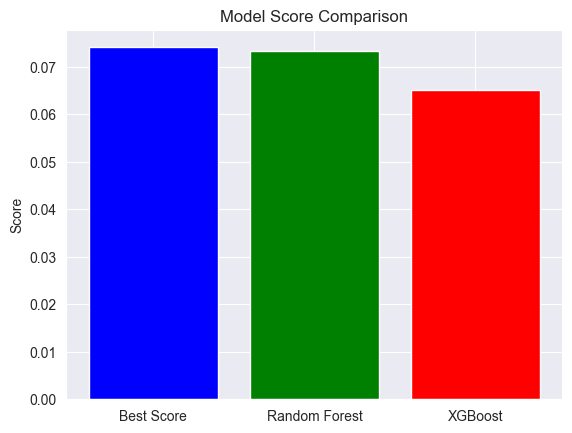

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Your best score
best_score = 0.07408

# Current score
current_score = mae

XG_score = 0.06505

# Data to plot
scores = [best_score, current_score, XG_score]

# Create figure and axes
fig, ax = plt.subplots()

# Create bar chart
ax.bar(['Best Score', 'Random Forest', 'XGBoost'], scores, color=['blue', 'green', 'red'])

# Set title and labels
ax.set_title('Model Score Comparison')
ax.set_ylabel('Score')

# Show the plot
plt.show()
